In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install ultralytics # install
from ultralytics import YOLO, checks
import os, torch, json, math, csv
from PIL import Image, ImageDraw
import numpy as np
from tqdm import tqdm
from torch import nn, Tensor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.optim as optim
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/practice/download/model')
from mobilenet import mobilenetv4_conv_medium
import pandas as pd

# **이미지 전처리(암꽃 분할)**

In [ ]:
# YOLO 모델 로드 및 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = '/content/drive/MyDrive/Colab Notebooks/practice/download/model/yolo.pt'
model = YOLO(model_path)
model.eval()
model.to(device)

checks()
print(device)

Ultralytics 8.3.59 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 32.8/112.6 GB disk)
cuda


In [ ]:
# 디렉토리 경로 설정
img_dir = '/content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images'
output_dir = '/content/drive/MyDrive/Colab Notebooks/practice/download/dataset/seg_images'
os.makedirs(output_dir, exist_ok=True)

# 이미지 파일 목록 가져오기
file_names = os.listdir(img_dir)

# 이미지 전처리
for file_name in tqdm(file_names, desc="Processing segmentation", leave=False):
    img_path = os.path.join(img_dir, file_name)
    output_path = os.path.join(output_dir, os.path.splitext(file_name)[0] + ".png")

    # 꽃 분할
    results = model.predict(img_path, conf=0.4)

    if not results or not hasattr(results[0], 'boxes') or not hasattr(results[0], 'masks'):
        print(f"{img_path} not saved: No detections")
        continue

    boxes = results[0].boxes
    masks = results[0].masks

    if boxes.conf is None or boxes.conf.numel() == 0:
        print(f"{img_path} not saved: No detections")
        continue

    max_conf_idx = boxes.conf.argmax().item()

    mask = masks.xy[max_conf_idx] if masks.xy else None

    if mask is not None and len(mask) > 0:
        try:
            img = Image.open(img_path).convert('RGB')

            mask_img = Image.new('L', img.size, 0)
            ImageDraw.Draw(mask_img).polygon(mask, fill=1)
            mask_array = np.array(mask_img)

            img_array = np.array(img)
            img_array[mask_array == 0] = 0

            seg_img = Image.fromarray(img_array)
            seg_img.save(output_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    else:
        print(f"{img_path} not saved: No mask detected")

Processing segmentation:   0%|          | 0/100 [00:00<?, ?it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_c12_A_1_7_22-09-26-11-56-1021.jpg: 480x640 1 flower, 16.9ms
Speed: 2.8ms preprocess, 16.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   1%|          | 1/100 [00:00<00:33,  2.99it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_a02_A_3_1_22-09-29-09-12-1021.jpg: 480x640 1 flower, 18.3ms
Speed: 4.2ms preprocess, 18.3ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   2%|▏         | 2/100 [00:00<00:44,  2.22it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b04_B_2_1_22-10-11-10-05-1021.jpg: 480x640 1 flower, 17.0ms
Speed: 3.1ms preprocess, 17.0ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   3%|▎         | 3/100 [00:01<00:39,  2.45it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b09_B_3_4_22-10-17-10-35-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   4%|▍         | 4/100 [00:01<00:39,  2.42it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_c02_A_2_4_22-10-04-09-19-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 4.1ms preprocess, 16.8ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   5%|▌         | 5/100 [00:02<00:40,  2.35it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c09_B_3_3_22-09-01-10-48-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 4.1ms preprocess, 16.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   6%|▌         | 6/100 [00:02<00:44,  2.10it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_d08_A_1_1_22-08-25-10-43-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 3.1ms preprocess, 16.8ms inference, 4.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   7%|▋         | 7/100 [00:03<00:46,  2.01it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b12_A_1_4_22-10-07-09-38-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 4.2ms preprocess, 16.8ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   8%|▊         | 8/100 [00:03<00:48,  1.91it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b13_B_2_3_22-10-06-10-21-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 4.1ms preprocess, 16.8ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:   9%|▉         | 9/100 [00:04<00:47,  1.93it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b06_B_2_1_22-08-30-10-52-1020.jpg: 480x640 1 flower, 18.2ms
Speed: 4.2ms preprocess, 18.2ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  10%|█         | 10/100 [00:04<00:45,  1.96it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_d13_B_3_1_22-09-06-11-20-1010.jpg: 480x640 1 flower, 17.0ms
Speed: 4.2ms preprocess, 17.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  11%|█         | 11/100 [00:05<00:46,  1.93it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b12_B_3_1_22-08-30-11-07-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 4.1ms preprocess, 16.8ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  12%|█▏        | 12/100 [00:05<00:45,  1.94it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c12_A_3_1_22-09-08-13-23-1021.jpg: 480x640 1 flower, 16.9ms
Speed: 3.9ms preprocess, 16.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  13%|█▎        | 13/100 [00:06<00:42,  2.03it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_a09_A_3_3_22-09-01-09-55-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  14%|█▍        | 14/100 [00:06<00:38,  2.26it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_a06_A_2_3_22-09-21-10-16-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  15%|█▌        | 15/100 [00:06<00:36,  2.36it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_a06_A_3_5_22-10-06-09-35-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  16%|█▌        | 16/100 [00:07<00:33,  2.50it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_c07_B_3_1_22-09-19-10-33-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  17%|█▋        | 17/100 [00:07<00:31,  2.67it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_d12_A_2_2_22-09-20-10-02-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  18%|█▊        | 18/100 [00:07<00:29,  2.81it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_a02_B_3_1_22-09-08-11-18-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  19%|█▉        | 19/100 [00:08<00:27,  2.91it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b03_A_2_2_22-09-16-15-30-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  20%|██        | 20/100 [00:08<00:26,  2.97it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c13_A_3_3_22-08-30-13-40-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 2.4ms preprocess, 16.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  21%|██        | 21/100 [00:08<00:26,  2.99it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b04_B_2_2_22-09-28-09-16-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  22%|██▏       | 22/100 [00:09<00:25,  3.02it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b10_A_1_1_22-10-06-09-32-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  23%|██▎       | 23/100 [00:09<00:27,  2.84it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c06_A_2_3_22-09-02-10-03-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  24%|██▍       | 24/100 [00:09<00:26,  2.90it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b14_A_3_3_22-09-02-11-08-1011.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  25%|██▌       | 25/100 [00:10<00:27,  2.76it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b14_B_3_1_22-09-28-09-39-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  26%|██▌       | 26/100 [00:10<00:27,  2.71it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b03_B_2_1_22-08-29-10-40-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  27%|██▋       | 27/100 [00:11<00:26,  2.79it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b04_A_3_4_22-10-07-09-16-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  28%|██▊       | 28/100 [00:11<00:25,  2.83it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_a12_A_3_1_22-09-13-11-20-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  29%|██▉       | 29/100 [00:11<00:24,  2.86it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_a01_A_1_2_22-08-31-11-03-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.9ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  30%|███       | 30/100 [00:12<00:23,  2.97it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b12_A_1_1_22-09-30-10-16-1010.jpg: 480x640 1 flower, 17.3ms
Speed: 5.9ms preprocess, 17.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  31%|███       | 31/100 [00:12<00:23,  2.93it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c09_B_2_1_22-09-01-10-47-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  32%|███▏      | 32/100 [00:12<00:23,  2.85it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_a08_A_1_3_22-10-03-09-44-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  33%|███▎      | 33/100 [00:13<00:22,  2.98it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b12_B_3_2_22-09-23-10-28-1031.jpg: 480x640 1 flower, 16.7ms
Speed: 2.9ms preprocess, 16.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  34%|███▍      | 34/100 [00:13<00:21,  3.03it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c07_B_2_1_22-08-23-13-31-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 3.9ms preprocess, 16.8ms inference, 22.7ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  35%|███▌      | 35/100 [00:14<00:27,  2.35it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_a05_B_2_3_22-09-02-10-00-1020.jpg: 480x640 1 flower, 22.3ms
Speed: 25.0ms preprocess, 22.3ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  36%|███▌      | 36/100 [00:14<00:32,  1.99it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b05_A_3_6_22-09-20-14-01-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 3.8ms preprocess, 16.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  37%|███▋      | 37/100 [00:15<00:32,  1.92it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_d05_B_2_1_22-08-24-13-49-1010.jpg: 480x640 1 flower, 20.6ms
Speed: 2.9ms preprocess, 20.6ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  38%|███▊      | 38/100 [00:15<00:29,  2.11it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_c08_B_3_1_22-09-06-10-37-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  39%|███▉      | 39/100 [00:16<00:27,  2.21it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_a04_A_3_1_22-08-29-09-59-1021.jpg: 480x640 1 flower, 17.3ms
Speed: 3.7ms preprocess, 17.3ms inference, 18.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  40%|████      | 40/100 [00:17<00:38,  1.54it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_d05_A_2_1_22-09-22-12-39-1021.jpg: 480x640 1 flower, 34.0ms
Speed: 11.2ms preprocess, 34.0ms inference, 9.7ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  41%|████      | 41/100 [00:18<00:45,  1.29it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b04_B_3_1_22-09-13-13-15-1020.jpg: 480x640 1 flower, 75.1ms
Speed: 36.4ms preprocess, 75.1ms inference, 14.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  42%|████▏     | 42/100 [00:20<01:07,  1.16s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b03_A_2_1_22-08-29-09-59-1020.jpg: 480x640 1 flower, 79.1ms
Speed: 28.5ms preprocess, 79.1ms inference, 12.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  43%|████▎     | 43/100 [00:21<01:11,  1.26s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c07_A_3_2_22-09-01-09-43-1010.jpg: 480x640 1 flower, 38.6ms
Speed: 7.5ms preprocess, 38.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  44%|████▍     | 44/100 [00:22<01:01,  1.10s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c02_A_2_3_22-08-31-10-21-1020.jpg: 480x640 1 flower, 17.3ms
Speed: 4.4ms preprocess, 17.3ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  45%|████▌     | 45/100 [00:23<00:57,  1.05s/it]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_a10_B_2_1_22-09-23-10-33-1020.jpg: 480x640 1 flower, 16.9ms
Speed: 3.9ms preprocess, 16.9ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  46%|████▌     | 46/100 [00:24<00:49,  1.08it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b06_B_2_2_22-09-21-11-04-1031.jpg: 480x640 1 flower, 28.9ms
Speed: 6.6ms preprocess, 28.9ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  47%|████▋     | 47/100 [00:24<00:43,  1.21it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_a09_B_3_3_22-09-21-11-13-1031.jpg: 480x640 1 flower, 17.3ms
Speed: 2.6ms preprocess, 17.3ms inference, 3.3ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  48%|████▊     | 48/100 [00:25<00:34,  1.49it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c02_A_2_1_22-09-21-10-04-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  49%|████▉     | 49/100 [00:25<00:29,  1.74it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_c11_A_3_3_22-10-06-11-11-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  50%|█████     | 50/100 [00:25<00:25,  1.94it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_c13_A_1_5_22-10-14-14-33-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  51%|█████     | 51/100 [00:26<00:22,  2.18it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b02_B_2_3_22-10-06-09-50-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  52%|█████▏    | 52/100 [00:26<00:20,  2.38it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_a08_A_2_6_22-09-22-09-28-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  53%|█████▎    | 53/100 [00:26<00:18,  2.51it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c02_B_3_2_22-09-08-13-32-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  54%|█████▍    | 54/100 [00:27<00:17,  2.67it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c03_B_1_1_22-08-26-09-51-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  55%|█████▌    | 55/100 [00:27<00:16,  2.71it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c08_A_2_1_22-08-24-14-43-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  56%|█████▌    | 56/100 [00:27<00:15,  2.80it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b01_A_2_2_22-09-14-11-13-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  57%|█████▋    | 57/100 [00:28<00:14,  2.88it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_a12_B_3_1_22-08-29-10-48-1010.jpg: 480x640 1 flower, 16.9ms
Speed: 2.6ms preprocess, 16.9ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  58%|█████▊    | 58/100 [00:28<00:14,  2.99it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b14_A_3_6_22-09-26-15-56-1020.jpg: 480x640 1 flower, 17.3ms
Speed: 3.5ms preprocess, 17.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  59%|█████▉    | 59/100 [00:28<00:13,  2.94it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b05_B_2_1_22-08-30-10-50-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 2.4ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  60%|██████    | 60/100 [00:29<00:13,  2.98it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_a10_A_3_2_22-08-30-10-10-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  61%|██████    | 61/100 [00:29<00:13,  3.00it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b11_A_3_3_22-10-04-09-40-1030.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  62%|██████▏   | 62/100 [00:29<00:12,  3.08it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_a05_A_1_1_22-09-30-09-16-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  63%|██████▎   | 63/100 [00:30<00:12,  2.99it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b04_B_2_5_22-10-05-10-04-1020.jpg: 480x640 1 flower, 16.7ms
Speed: 4.1ms preprocess, 16.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  64%|██████▍   | 64/100 [00:30<00:12,  2.93it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c01_B_3_5_22-09-23-11-09-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  65%|██████▌   | 65/100 [00:30<00:12,  2.91it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_a13_A_3_5_22-10-06-09-55-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  66%|██████▌   | 66/100 [00:31<00:11,  2.91it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_a07_A_2_5_22-09-16-14-43-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.4ms preprocess, 16.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  67%|██████▋   | 67/100 [00:31<00:11,  2.84it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b06_A_2_2_22-09-30-10-10-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  68%|██████▊   | 68/100 [00:31<00:11,  2.89it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_c05_A_2_4_22-10-07-09-22-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  69%|██████▉   | 69/100 [00:32<00:11,  2.79it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b02_B_3_1_22-09-21-11-49-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 5.9ms preprocess, 16.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  70%|███████   | 70/100 [00:32<00:12,  2.41it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b05_A_1_2_22-09-02-10-35-1020.jpg: 480x640 1 flower, 16.9ms
Speed: 4.6ms preprocess, 16.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  71%|███████   | 71/100 [00:33<00:13,  2.19it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b06_B_3_1_22-09-13-13-20-1010.jpg: 480x640 1 flower, 16.9ms
Speed: 5.8ms preprocess, 16.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  72%|███████▏  | 72/100 [00:33<00:13,  2.13it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c14_A_3_3_22-09-02-10-23-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 4.0ms preprocess, 16.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  73%|███████▎  | 73/100 [00:34<00:13,  2.05it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c11_A_3_1_22-08-29-13-25-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 4.4ms preprocess, 16.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  74%|███████▍  | 74/100 [00:34<00:13,  1.98it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_c06_B_3_5_22-10-07-10-12-1010.jpg: 480x640 1 flower, 19.8ms
Speed: 4.2ms preprocess, 19.8ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  75%|███████▌  | 75/100 [00:35<00:12,  1.99it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_d11_B_1_4_22-10-07-13-30-1021.jpg: 480x640 1 flower, 16.9ms
Speed: 4.2ms preprocess, 16.9ms inference, 3.2ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  76%|███████▌  | 76/100 [00:35<00:12,  1.99it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_d05_B_3_5_22-10-07-11-22-1031.jpg: 480x640 1 flower, 16.9ms
Speed: 4.1ms preprocess, 16.9ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  77%|███████▋  | 77/100 [00:36<00:11,  1.96it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_d09_A_1_1_22-10-06-11-23-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 4.3ms preprocess, 16.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  78%|███████▊  | 78/100 [00:36<00:11,  1.95it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_c02_A_1_2_22-09-26-11-22-1021.jpg: 480x640 1 flower, 16.9ms
Speed: 3.9ms preprocess, 16.9ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  79%|███████▉  | 79/100 [00:37<00:10,  2.06it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c01_A_3_1_22-08-24-14-27-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  80%|████████  | 80/100 [00:37<00:08,  2.23it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b02_B_3_1_22-08-25-10-33-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  81%|████████  | 81/100 [00:38<00:07,  2.41it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_d10_A_3_4_22-10-14-11-01-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.4ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  82%|████████▏ | 82/100 [00:38<00:06,  2.63it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_d02_A_3_1_22-10-04-09-20-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  83%|████████▎ | 83/100 [00:38<00:06,  2.69it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b07_B_2_5_22-10-03-10-50-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  84%|████████▍ | 84/100 [00:39<00:06,  2.61it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b10_A_3_8_22-09-26-15-43-1021.jpg: 480x640 1 flower, 16.9ms
Speed: 3.9ms preprocess, 16.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  85%|████████▌ | 85/100 [00:39<00:05,  2.72it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b14_B_1_2_22-08-30-11-12-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 2.9ms preprocess, 16.8ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  86%|████████▌ | 86/100 [00:39<00:05,  2.78it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_a10_A_1_2_22-09-01-09-57-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  87%|████████▋ | 87/100 [00:40<00:04,  2.91it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_a06_B_2_1_22-10-17-09-54-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  88%|████████▊ | 88/100 [00:40<00:03,  3.00it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b03_B_3_1_22-09-06-10-59-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  89%|████████▉ | 89/100 [00:40<00:03,  2.98it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c04_A_2_1_22-09-05-10-48-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  90%|█████████ | 90/100 [00:41<00:03,  3.04it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c09_A_2_2_22-08-31-10-48-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  91%|█████████ | 91/100 [00:41<00:03,  2.84it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_d03_A_1_3_22-10-12-10-56-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  92%|█████████▏| 92/100 [00:41<00:02,  2.80it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c09_A_2_2_22-08-30-13-31-1010.jpg: 480x640 1 flower, 16.7ms
Speed: 2.7ms preprocess, 16.7ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  93%|█████████▎| 93/100 [00:42<00:02,  2.93it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b02_B_3_1_22-09-23-10-01-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.5ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  94%|█████████▍| 94/100 [00:42<00:02,  2.97it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_b04_B_1_1_22-09-16-10-27-1021.jpg: 480x640 1 flower, 16.8ms
Speed: 2.4ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  95%|█████████▌| 95/100 [00:42<00:01,  2.94it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_b09_B_3_3_22-08-31-10-12-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  96%|█████████▌| 96/100 [00:43<00:01,  2.90it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_a02_B_3_5_22-10-07-10-59-1020.jpg: 480x640 1 flower, 16.8ms
Speed: 2.6ms preprocess, 16.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  97%|█████████▋| 97/100 [00:43<00:00,  3.02it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c13_B_3_2_22-09-22-13-30-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  98%|█████████▊| 98/100 [00:43<00:00,  2.92it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_d06_A_1_1_22-08-25-10-37-1010.jpg: 480x640 1 flower, 16.8ms
Speed: 2.8ms preprocess, 16.8ms inference, 4.5ms postprocess per image at shape (1, 3, 480, 640)


Processing segmentation:  99%|█████████▉| 99/100 [00:44<00:00,  2.76it/s]


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c07_A_3_6_22-09-15-10-41-1031.jpg: 480x640 1 flower, 16.8ms
Speed: 2.7ms preprocess, 16.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


In [ ]:
# YOLO 예시
sample_path = '/content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/A_d09_A_1_1_22-10-06-11-23-1020.jpg'
results = model.predict(img_path, conf=0.0001)

results[0].boxes.conf
# results[0].masks.xy


image 1/1 /content/drive/MyDrive/Colab Notebooks/practice/download/dataset/images/B_c07_A_3_6_22-09-15-10-41-1031.jpg: 480x640 7 flowers, 16.8ms
Speed: 2.4ms preprocess, 16.8ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


tensor([8.6293e-01, 4.4671e-04, 3.3697e-04, 2.5276e-04, 2.0432e-04, 1.2895e-04, 1.1883e-04], device='cuda:0')

# **데이터셋 정의**

In [ ]:
# 입력 및 라벨 디렉토리 설정
input_dir = '/content/drive/MyDrive/Colab Notebooks/practice/download/dataset/seg_images'
label_dir = '/content/drive/MyDrive/Colab Notebooks/practice/download/dataset/labels'

def load_dataset(input_dir, label_dir):
    intput_files = os.listdir(input_dir)
    label_files = os.listdir(label_dir)

    dataset = []
    for input_file in intput_files:
        label_file = input_file.replace('.png', '.json')
        with open(os.path.join(label_dir, label_file), 'r') as f:
            label_data = json.load(f)
            browning = label_data['annotations']['polygon'][0]['browning']

        dataset.append({
            'image_path': os.path.join(input_dir, input_file),
            'label': f'{browning}'
        })
    return dataset

dataset = load_dataset(input_dir, label_dir)
labels = [data['label'] for data in dataset]

# 데이터 분할
train_split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, temp_idx in train_split.split(dataset, labels):
    train_set = [dataset[i] for i in train_idx]
    temp_set = [dataset[i] for i in temp_idx]
val_test_split = StratifiedShuffleSplit(n_splits=1, test_size=2/3, random_state=42)
labels_temp = [labels[i] for i in temp_idx]
for val_idx, test_idx in val_test_split.split(temp_set, labels_temp):
    val_set = [temp_set[i] for i in val_idx]
    test_set = [temp_set[i] for i in test_idx]

# 클래스별 개수 확인
train_label_count = Counter([data['label'] for data in train_set])
val_label_count   = Counter([data['label'] for data in val_set])
test_label_count  = Counter([data['label'] for data in test_set])

print("Train set class counts:", train_label_count)
print("Validation set class counts:", val_label_count)
print("Test set class counts:", test_label_count)

Train set class counts: Counter({'True': 35, 'False': 35})
Validation set class counts: Counter({'False': 5, 'True': 5})
Test set class counts: Counter({'False': 10, 'True': 10})


In [ ]:
# 전처리 설정
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean=MEAN, std=STD)
transform = transforms.Compose([
    transforms.ToTensor()])

def preprocess_image(image):
    non_zero_mask = (image > 0).any(axis=-1)
    non_zero_rows = np.any(non_zero_mask, axis=1)
    non_zero_cols = np.any(non_zero_mask, axis=0)
    min_row, max_row = np.where(non_zero_rows)[0][[0, -1]]
    min_col, max_col = np.where(non_zero_cols)[0][[0, -1]]
    image = image[min_row:max_row+1, min_col:max_col+1]
    image = Image.fromarray(image)
    image = image.resize((224, 224))
    return image

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, num_classes=2):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.num_classes = num_classes

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert('RGB'))
        image = preprocess_image(image)
        label = int(self.labels[idx])

        if self.transform:
            image = self.transform(image)
        return image, label

def create_dataloader(dataset, transform, batch_size, shuffle, num_workers):
    image_paths = [item['image_path'] for item in dataset]
    labels = [0 if item['label'] == 'True' else 1 for item in dataset]
    custom_dataset = CustomDataset(image_paths, labels, transform=transform)
    return DataLoader(custom_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# 데이터로더 생성
train_loader = create_dataloader(train_set, transform, batch_size=24, shuffle=True, num_workers=2)
val_loader = create_dataloader(val_set, transform, batch_size=24, shuffle=False, num_workers=2)
test_loader = create_dataloader(test_set, transform, batch_size=24, shuffle=False, num_workers=2)

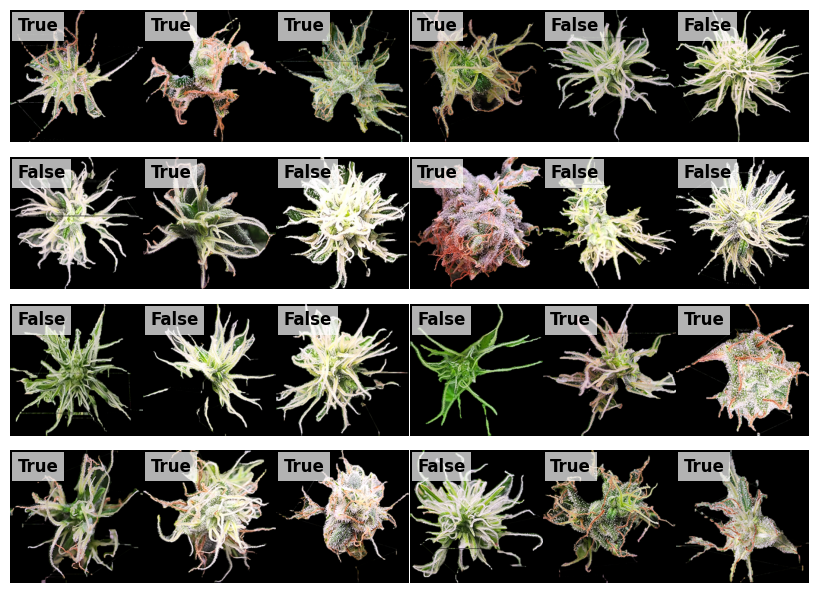

In [ ]:
# 샘플 이미지 확인
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(8, 6))
axes = axes.flatten()

for idx, img in enumerate(images):
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))

    axes[idx].imshow(img)
    axes[idx].axis('off')

    label = labels[idx].cpu().item()
    label_str = 'False' if label == 1 else 'True'

    axes[idx].text(
        12, 12, label_str,
        color='black', ha='left', va='top',
        fontsize=12, fontweight='bold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )

plt.tight_layout(pad=0.05, h_pad=0.05, w_pad=0.05)
plt.show()

# **모델 및 손실 함수 정의**

In [ ]:
# 모델 및 하이퍼파라미터 설정
model = mobilenetv4_conv_medium(num_classes=2)
for params in model.parameters():
        params.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=0.001)

model.to(device)

CE = nn.CrossEntropyLoss()

# **모델 학습**

In [ ]:
# 디렉토리 설정
model_dir = '/content/drive/MyDrive/Colab Notebooks/practice/model'
os.makedirs(model_dir, exist_ok=True)
log_dir = '/content/drive/MyDrive/Colab Notebooks/practice/log'
os.makedirs(log_dir, exist_ok=True)

model_path = os.path.join(model_dir, 'pretrain.pth')
log_csv_path = os.path.join(log_dir, 'training_log.csv')

num_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

# 모델 학습
def train_val_epoch(model, dataloader, phase, optimizer=None):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    for inputs, labels in tqdm(dataloader, desc=f'  {phase} Progress', leave=False):
        inputs = normalize(inputs).to(device)
        labels = labels.to(device)

        if phase == 'train':
            optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = CE(outputs, labels)
            _, preds = torch.max(outputs, 1)

            if phase == 'train':
                loss.backward()
                optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        all_preds.extend(preds.detach().cpu().numpy())
        all_labels.extend(labels.detach().cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
    epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

    epoch_metrics = {
        'loss': epoch_loss,
        'accuracy': epoch_acc,
        'precision': epoch_precision,
        'recall': epoch_recall,
        'f1': epoch_f1
    }

    return epoch_loss, epoch_acc, epoch_metrics

best_model_wts = model.state_dict()

# CSV 파일에 에포크별 로그 작성
with open(log_csv_path, 'w', newline='') as csvfile:
    fieldnames = [
        'epoch',
        'train_loss', 'train_acc', 'train_precision', 'train_recall', 'train_f1',
        'val_loss', 'val_acc', 'val_precision', 'val_recall', 'val_f1'
    ]
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}:")

        train_loss, train_acc, train_metrics = train_val_epoch(model, train_loader, 'train', optimizer)
        val_loss, val_acc, val_metrics = train_val_epoch(model, val_loader, 'val')

        print(f"  Train Metrics:      Loss={train_loss:.4f}, Acc={train_acc:.4f}, "
              f"Precision={train_metrics['precision']:.4f}, "
              f"Recall={train_metrics['recall']:.4f}, "
              f"F1={train_metrics['f1']:.4f}")
        print(f"  Validation Metrics: Loss={val_loss:.4f}, Acc={val_acc:.4f}, "
              f"Precision={val_metrics['precision']:.4f}, "
              f"Recall={val_metrics['recall']:.4f}, "
              f"F1={val_metrics['f1']:.4f}")

        # CSV 파일에 현재 에포크의 로그 작성
        writer.writerow({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'train_precision': train_metrics['precision'],
            'train_recall': train_metrics['recall'],
            'train_f1': train_metrics['f1'],
            'val_loss': val_loss,
            'val_acc': val_acc,
            'val_precision': val_metrics['precision'],
            'val_recall': val_metrics['recall'],
            'val_f1': val_metrics['f1']
        })

        # 모델 저장 및 조기 종료 로직
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            torch.save(best_model_wts, model_path)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"  Patience: {epochs_no_improve}")
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

Epoch 1/50:


  Train Metrics:      Loss=0.6977, Acc=0.5857, Precision=0.5858, Recall=0.5857, F1=0.5856
  Validation Metrics: Loss=0.7121, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
Epoch 2/50:


  Train Metrics:      Loss=0.3975, Acc=0.7857, Precision=0.7859, Recall=0.7857, F1=0.7857
  Validation Metrics: Loss=0.7316, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
  Patience: 1
Epoch 3/50:


  Train Metrics:      Loss=0.2141, Acc=0.8857, Precision=0.8857, Recall=0.8857, F1=0.8857
  Validation Metrics: Loss=0.7567, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
  Patience: 2
Epoch 4/50:


  Train Metrics:      Loss=0.1546, Acc=0.9571, Precision=0.9605, Recall=0.9571, F1=0.9571
  Validation Metrics: Loss=0.8081, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
  Patience: 3
Epoch 5/50:


  Train Metrics:      Loss=0.0638, Acc=0.9857, Precision=0.9861, Recall=0.9857, F1=0.9857
  Validation Metrics: Loss=0.8485, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
  Patience: 4
Epoch 6/50:


  Train Metrics:      Loss=0.0985, Acc=0.9714, Precision=0.9730, Recall=0.9714, F1=0.9714
  Validation Metrics: Loss=0.9456, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333
  Patience: 5
Early stopping at epoch 6


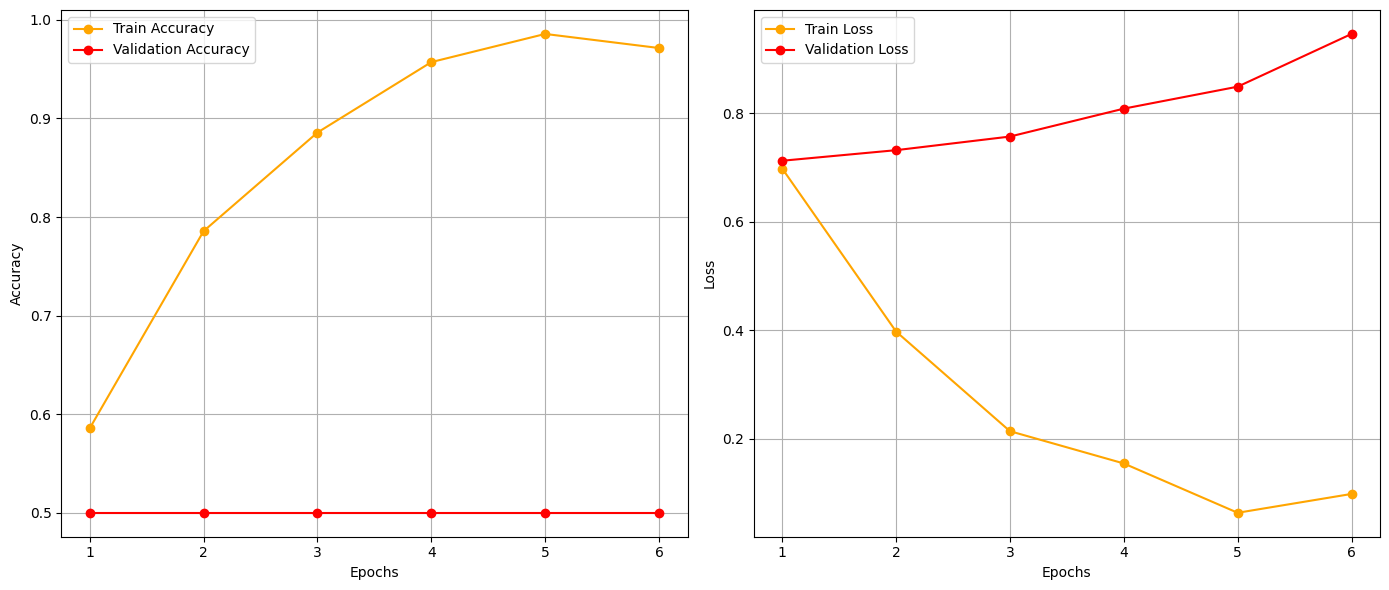

In [ ]:
# 로그 파일 읽기
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/practice/log/training_log.csv')

epochs = df['epoch']
train_acc = df['train_acc']
val_acc = df['val_acc']
train_loss = df['train_loss']
val_loss = df['val_loss']

# 정확도 그래프
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].plot(epochs, train_acc, label='Train Accuracy', marker='o', color='orange')
axes[0].plot(epochs, val_acc, label='Validation Accuracy', marker='o', color='red')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid()

# 손실 그래프
axes[1].plot(epochs, train_loss, label='Train Loss', marker='o', color='orange')
axes[1].plot(epochs, val_loss, label='Validation Loss', marker='o', color='red')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()

# **모델 추론 및 평가**

In [ ]:
# 모델 로드 및 설정
model = mobilenetv4_conv_medium(num_classes=2)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

total_loss = 0.0
correct_predictions = 0
all_labels = []
all_preds = []

# 테스트 데이터 평가
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Test Progress', leave=False):
        inputs = normalize(inputs).to(device)
        labels = labels.to(device)

        outputs = model(inputs) # 모델 예측
        loss = CE(outputs, labels) # 손실 계산
        _, preds = torch.max(outputs, 1) # 예측 클래스 도출

        total_loss += loss.item() * inputs.size(0)
        correct_predictions += (preds == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# 평가지표 계산
avg_test_loss = total_loss / len(test_loader.dataset)
avg_test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

print(f"Test Metrics: "
      f"Loss={avg_test_loss:.4f}, "
      f"Acc={avg_test_acc:.4f}, "
      f"Precision={test_precision:.4f}, "
      f"Recall={test_recall:.4f}, "
      f"F1={test_f1:.4f}")

Test Metrics: Loss=0.7121, Acc=0.5000, Precision=0.7500, Recall=0.5000, F1=0.3333


In [ ]:
# 사전 학습 모델 로드 및 평가
pretrained_model_path = '/content/drive/MyDrive/Colab Notebooks/practice/download/model/pretrain.pth'
pretrained_model = mobilenetv4_conv_medium(num_classes=2)
pretrained_model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
pretrained_model.to(device)
pretrained_model.eval()

total_loss = 0.0
correct_predictions = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Test Progress', leave=False):
        inputs = normalize(inputs).to(device)
        labels = labels.to(device)

        outputs = pretrained_model(inputs)
        loss = CE(outputs, labels)
        _, preds = torch.max(outputs, 1)

        total_loss += loss.item() * inputs.size(0)
        correct_predictions += (preds == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

avg_test_loss = total_loss / len(test_loader.dataset)
avg_test_acc = accuracy_score(all_labels, all_preds)
test_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=1)
test_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=1)
test_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=1)

print(f"Test Metrics: "
      f"Loss={avg_test_loss:.4f}, "
      f"Acc={avg_test_acc:.4f}, "
      f"Precision={test_precision:.4f}, "
      f"Recall={test_recall:.4f}, "
      f"F1={test_f1:.4f}")

Test Metrics: Loss=0.0810, Acc=1.0000, Precision=1.0000, Recall=1.0000, F1=1.0000
